In [53]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

### Neural machine translation with attention

In [54]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

### Download and prepare the dataset

We'll use a language dataset provided by http://www.manythings.org/anki/

In [55]:
!wget http://www.manythings.org/anki/swe-eng.zip

--2023-05-19 06:24:25--  http://www.manythings.org/anki/swe-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 744068 (727K) [application/zip]
Saving to: ‘swe-eng.zip.1’

swe-eng.zip.1       100%[===================>] 726.63K  --.-KB/s    in 0.1s    

2023-05-19 06:24:25 (6.29 MB/s) - ‘swe-eng.zip.1’ saved [744068/744068]



In [58]:
!mkdir swe-eng
!unzip swe-eng -d swe-eng/

mkdir: cannot create directory ‘swe-eng’: File exists
Archive:  swe-eng.zip
replace swe-eng/_about.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [59]:
!ls /kaggle/working/swe-eng -lah

total 3.1M
drwxr-xr-x 2 root root 4.0K May 19 06:04 .
drwxr-xr-x 4 root root 4.0K May 19 06:24 ..
-rw-r--r-- 1 root root 1.5K Apr  2 03:16 _about.txt
-rw-r--r-- 1 root root 3.0M Apr  2 03:16 swe.txt


In [61]:
# Download the file
path_to_file = "/kaggle/working/swe-eng/swe.txt"

In [62]:
def preprocess_sentence(w):
  w = w.lower().strip()

  # creating a space between a word and the punctuation following it
  # eg: "he is a boy." => "he is a boy ."
  # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
  w = re.sub(r"([?.!,])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)

  # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
  w = re.sub(r"[^a-zA-Zа-яА-Я?.!,']+", " ", w)

  w = w.strip()

  # adding a start and an end token to the sentence
  # so that the model know when to start and stop predicting.
  w = '< start > ' + w + ' <end >'
  return w

In [63]:
preprocess_sentence("I can't go.")

"< start > i can't go . <end >"

In [64]:
# 1. Remove the accents
# 2. Clean the sentences
# 3. Return word pairs in the format: [ENG, RUS]
def create_dataset(path, num_examples):
  lines = io.open(path, encoding='UTF-8').read().strip().split('\n')

  word_pairs = [[preprocess_sentence(w) for w in l.split('\t')[:2]]  for l in lines[:num_examples]]

  return zip(*word_pairs)

In [65]:
en, swe = create_dataset(path_to_file, None)
print(en[-1])
print(swe[-1])

< start > i know that adding sentences only in your native or strongest language is probably not as much fun as practicing writing foreign languages , but please don't add sentences to the tatoeba corpus if you are not absolutely sure they are correct . if you want to practice languages that you are studying , please do so by using a website designed for that purpose such as www . lang . com . <end >
< start > jag vet att det nog inte r lika roligt att l gga till meningar p ditt modersm l eller starkaste spr k som att va p fr mmande spr k , men var v nlig och l gg inte till meningar i tatoebas korpus om du inte r fullst ndigt s ker p att de r korrekta . om du vill va p spr k du studerar , v nligen g r det p en hemsida avsedd f r det ndam let , s som www . lang . com . <end >


In [66]:
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

  return tensor, lang_tokenizer

In [67]:
def load_dataset(path, num_examples=None):
  # creating cleaned input, output pairs
  targ_lang, inp_lang = create_dataset(path, num_examples)

  input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
  target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

### Limit the size of the dataset to experiment faster (optional)

In [68]:
len(en), len(swe)

(23267, 23267)

In [69]:
# Try experimenting with the size of that dataset
num_examples = 100000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

In [70]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

18613 18613 4654 4654


In [73]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

In [74]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
2 ----> <
3 ----> start
1 ----> >
10 ----> det
15 ----> h
6 ----> r
6 ----> r
31 ----> den
15 ----> h
2202 ----> gsta
2116 ----> byggnad
45 ----> som
7 ----> jag
17 ----> n
297 ----> gonsin
18 ----> har
233 ----> sett
5 ----> .
4 ----> <end
1 ----> >

Target Language; index to word mapping
3 ----> <
2 ----> start
1 ----> >
19 ----> this
13 ----> is
10 ----> the
1808 ----> tallest
804 ----> building
16 ----> that
6 ----> i
17 ----> have
274 ----> ever
235 ----> seen
5 ----> .
4 ----> <end
1 ----> >


### Create a tf.data dataset

In [76]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [77]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 96]), TensorShape([64, 78]))

In [78]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [79]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 96, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [81]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [82]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 96, 1)


In [84]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [85]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 5865)


### Define the optimizer and the loss function

In [86]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

### Checkpoints (Object-based saving)

In [87]:
checkpoint_dir = './training_attention_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [92]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['start']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [93]:
EPOCHS = 50

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 1.1193
Epoch 1 Batch 100 Loss 0.4521
Epoch 1 Batch 200 Loss 0.4302
Epoch 1 Loss 0.4543
Time taken for 1 epoch 462.9144344329834 sec

Epoch 2 Batch 0 Loss 0.3292
Epoch 2 Batch 100 Loss 0.3262
Epoch 2 Batch 200 Loss 0.3473
Epoch 2 Loss 0.3457
Time taken for 1 epoch 356.53323125839233 sec

Epoch 3 Batch 0 Loss 0.2984
Epoch 3 Batch 100 Loss 0.2765
Epoch 3 Batch 200 Loss 0.3030
Epoch 3 Loss 0.2976
Time taken for 1 epoch 355.7590835094452 sec

Epoch 4 Batch 0 Loss 0.2687
Epoch 4 Batch 100 Loss 0.2719
Epoch 4 Batch 200 Loss 0.2297
Epoch 4 Loss 0.2592
Time taken for 1 epoch 356.9392161369324 sec

Epoch 5 Batch 0 Loss 0.2127
Epoch 5 Batch 100 Loss 0.2137
Epoch 5 Batch 200 Loss 0.2434
Epoch 5 Loss 0.2196
Time taken for 1 epoch 356.857798576355 sec

Epoch 6 Batch 0 Loss 0.1690
Epoch 6 Batch 100 Loss 0.1713
Epoch 6 Batch 200 Loss 0.1658
Epoch 6 Loss 0.1821
Time taken for 1 epoch 357.6180100440979 sec

Epoch 7 Batch 0 Loss 0.1529
Epoch 7 Batch 100 Loss 0.1546
Epoch 7 Batch 200 

### Translate

* The evaluate function is similar to the training loop, except we don't use teacher forcing here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
* Stop predicting when the model predicts the end token.
* And store the attention weights for every time step.

Note: The encoder output is calculated only once for one input.

In [108]:
def evaluate(sentence):
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  sentence = preprocess_sentence(sentence)

  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['start']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += targ_lang.index_word[predicted_id] + ' '

    if targ_lang.index_word[predicted_id] == 'end':
      return result, sentence, attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [137]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 10}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [138]:
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

### Restore the latest checkpoint and test

In [139]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: < start > det r trevligt h r . <end >
Predicted translation: start > it's here now here . <end > it's here now here . <end > it's here now here . <end > it's here now here . <end > it's here now here . <end > it's here now here . <end > it's here now here . <end > it's here now here . <end > it's here now here . <end > it's here now here . <end > it's here now here . <end 


/tmp/ipykernel_31/1583621366.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_31/1583621366.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


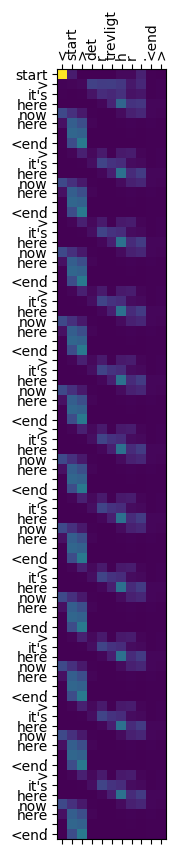

In [140]:
translate (u'Det är trevligt här.')

Input: < start > jag kan inte g . <end >
Predicted translation: start > i can't go out . <end > i can't go out . <end > i can't go out . <end > i can't go out . <end > i can't go out . <end > i can't go out . <end > i can't go out . <end > i can't go out . <end > i can't go out . <end > i can't go out . <end > i can't go out . <end 


/tmp/ipykernel_31/1583621366.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_31/1583621366.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


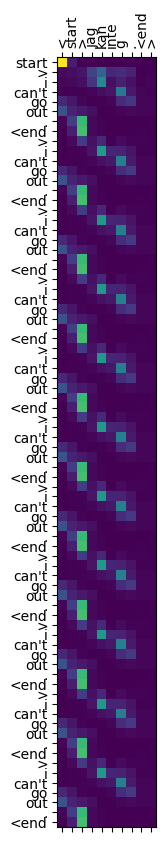

In [141]:
translate(u'jag kan inte gå.')

Input: < start > r du fortfarande hemma ? <end >
Predicted translation: start > are you still at home ? <end > are you still at home ? <end > are you still at home ? <end > are you still at home ? <end > are you still at home ? <end > are you still at home ? <end > are you still at home ? <end > are you still at home ? <end > are you still at home ? <end > are you still at 


/tmp/ipykernel_31/1583621366.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_31/1583621366.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


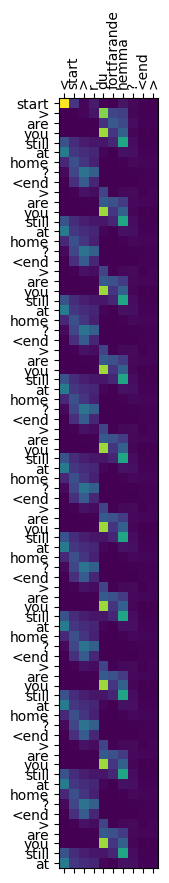

In [142]:
translate(u'är du fortfarande hemma?')

Input: < start > f rs k att g ra det . <end >
Predicted translation: start > try and do it . <end > try and do it . <end > try and do it . <end > try and do it . <end > try and do it . <end > try and do it . <end > try and do it . <end > try and do it . <end > try and do it . <end > try and do it . <end > try and do it . <end 


/tmp/ipykernel_31/1583621366.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_31/1583621366.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


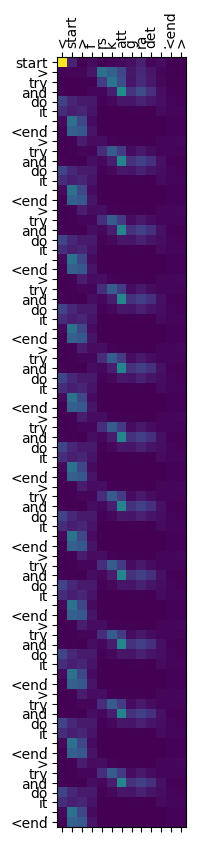

In [143]:
translate(u'försök att göra det.')

Input: < start > prova detta . <end >
Predicted translation: start > try this . <end > try this . <end > try this . <end > try this . <end > try this . <end > try this . <end > try this . <end > try this . <end > try this . <end > try this . <end > try this . <end > try this . <end > try this . <end > try this . <end > try this . <end > try 


/tmp/ipykernel_31/1583621366.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_31/1583621366.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


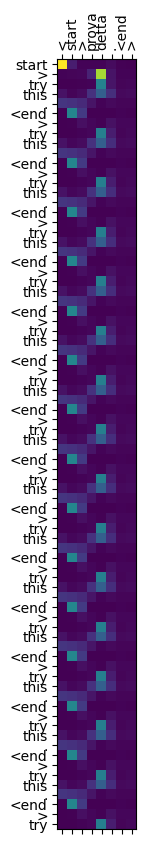

In [144]:
translate(u'Prova detta.')

Input: < start > jag gillar det inte n r det sn ar . <end >
Predicted translation: start > i don't like that song . <end > i don't like that song . <end > i don't like that song . <end > i don't like that song . <end > i don't like that song . <end > i don't like that song . <end > i don't like that song . <end > i don't like that song . <end > i don't like that song . <end > i don't like that 


/tmp/ipykernel_31/1583621366.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_31/1583621366.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


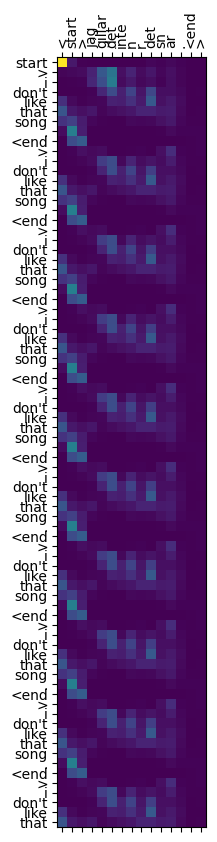

In [147]:
translate(u'Jag gillar det inte när det snöar.')

Input: < start > jag g r aldrig det . <end >
Predicted translation: start > i never do it . <end > i never do it . <end > i never do it . <end > i never do it . <end > i never do it . <end > i never do it . <end > i never do it . <end > i never do it . <end > i never do it . <end > i never do it . <end > i never do it . <end 


/tmp/ipykernel_31/1583621366.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_31/1583621366.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


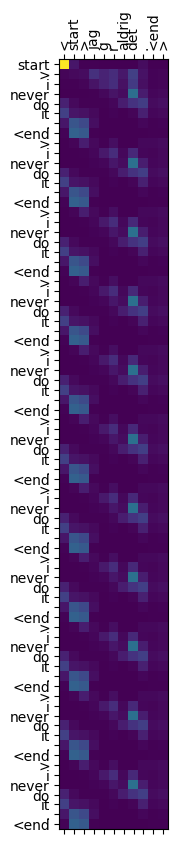

In [146]:
translate(u'Jag gör aldrig det.')